In [2]:
import torch
import torch_geometric
from torch_geometric.datasets import TUDataset, FakeDataset
from torch_geometric.data import DataLoader

### Generating example dataset

In [3]:
ds = TUDataset(root = "../data/", name = "MUTAG")
ds = FakeDataset(num_graphs = 100, avg_num_nodes = 10, avg_degree=2)

In [4]:
dl = DataLoader(ds, batch_size = 32, shuffle = True)

/Users/edebrouwer/miniconda3/envs/sheaf/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
for i,b in enumerate(dl):
    break

In [30]:
b

DataBatch(y=[32], edge_index=[2, 960], x=[314, 64], batch=[314], ptr=[33])

### Model generation

#### Pseudo-code

- Graph rewiring

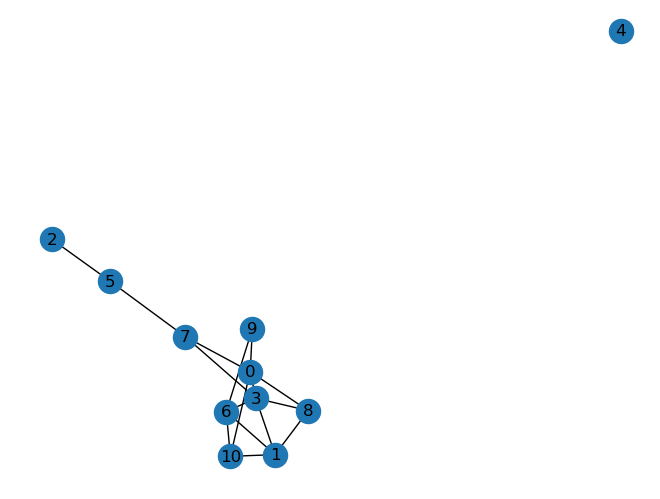

In [6]:
import networkx as nx

g = torch_geometric.utils.to_networkx(b[0], to_undirected=True)
nx.draw(g, with_labels=True)

In [93]:
# Getting all the paths of length k

def get_paths_length_k(A, k):
    """
    Returns the paths of length k in the graph A
    Shape : Num paths x k
    """
    last_A = A.clone()
    k_ = 1
    while k > k_:
        k_ +=1
        if k_ == 2:
            last_A = torch.einsum('ij,jk->ijk', A, A)
        elif k_==3:
            last_A = torch.einsum('ijk,kl->ijkl', last_A, A)
        elif k_ == 4:
            last_A = torch.einsum('ijkl,lm->ijklm', last_A, A)

    paths = torch.unique(torch.stack(torch.where(last_A!=0),0).T.sort(1)[0],dim=0) 
    return paths

In [94]:
# Create new node for each different path and link them to the original nodes
def update_graph(paths, nodes_dict, edge_index):
    num_nodes = len(nodes_dict)
    for path in paths:
        nodes_dict[num_nodes] = path.tolist()
        
        source_nodes = torch.Tensor([num_nodes]).repeat(3).long()
        new_edges_0 = torch.stack([source_nodes, path],0)
        new_edges_1 = torch.stack([path, source_nodes],0)
        new_edges = torch.cat([new_edges_0, new_edges_1],1)
        edge_index = torch.cat([edge_index, new_edges],1)
        num_nodes += 1
    return edge_index, nodes_dict

In [99]:
# Example

edge_index = b[0].edge_index # Getting the edge index of the graph

A = torch_geometric.utils.to_dense_adj(b[0].edge_index)[0] # Creates adjacency matrix

nodes_dict = {i: [i] for i in range(A.shape[0])} # Dictionary to keep track of the nodes

paths = get_paths_length_k(A, 2) # Get all the paths of length 2
edge_index, nodes_dict = update_graph(paths, nodes_dict, edge_index) # Append these paths to the graph

# WIP

In [73]:
A2 = torch.einsum('ij,jk->ijk', A, A)
A3 = torch.einsum('ijk,kl->ijkl', A2, A)
A4 = torch.einsum('ijkl,lm->ijklm', A3, A)
A5 = torch.einsum('ijklm,mn->ijklmn', A4, A)

In [88]:
.shape

torch.Size([65, 3])

In [77]:
A.sum()

tensor(22.)

tensor(0.)

In [19]:
from torch_geometric.nn import MessagePassing

In [ ]:
class AggGraphClass(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = nn.Linear(in_channels, out_channels, bias=False)
        self.bias = nn.Parameter(torch.empty(out_channels))

        self.node_emb = nn.Sequential(nn.Linear(out_channels,out_channels),nn.ReLU())

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        ## Step 1: Add self-loops to the adjacency matrix.
        #edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x)

        # Step 6: Apply a final bias vector.
        out += self.bias

        return out

    def message(self, x_j):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return self.node_emb(x_j)
    
    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]

        # Step 5: Return new node embeddings.
        return aggr_out